In [1]:
from __future__ import print_function, division
from sklearn.datasets import fetch_20newsgroups

In [26]:
from time import time
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn import metrics
import pandas as pd
import numpy as np
import os,itertools
import matplotlib.pyplot as plt
from utils import save,load,plot_confusion_matrix

In [3]:
if not os.path.exists('models20'):
    os.makedirs('models20')

# Part (1) : Building TF-IDF

In [4]:
twenty_train = fetch_20newsgroups(subset='all', shuffle=True,
                                  random_state=42, remove=('headers','footers','quotes'))
print("Length of training data ==>", len(twenty_train.data))

Length of training data ==> 18846


In [6]:
def initParams(tfidf_min_df):
    stemmer = SnowballStemmer('english')
    analyzer = CountVectorizer().build_analyzer()
    #Use token_pattern parameter with analyzer='word' if no stemming and want to remove words that are only numbers.
    vectorizer = CountVectorizer(stop_words='english', min_df=tfidf_min_df, max_df=0.8, analyzer="word",
                                 strip_accents='ascii', token_pattern='\w*[a-zA-Z]')
    tfidf_transformer = TfidfTransformer()
    return [stemmer, analyzer,vectorizer,tfidf_transformer]

def getTfidf(vectorizer,tfidf_transformer,data,isTraining=True):
    if(isTraining):
        count_data = vectorizer.fit_transform(data)
        tfidf_data = tfidf_transformer.fit_transform(count_data)
    else:
        count_data = vectorizer.transform(data)
        tfidf_data = tfidf_transformer.transform(count_data)        
    return tfidf_data

def stemmedWords(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

stemmer, analyzer,vectorizer,tfidf_transformer = initParams(tfidf_min_df=3)

load_from_previous = True

if(load_from_previous):
    training_data = load('models20/tfidf_training')
else:
    training_data = getTfidf(vectorizer,tfidf_transformer,twenty_train.data)
    save(training_data,'models20/tfidf_training')
print('---------------Report Dimensions:---------------')
print('Shape of Training Data ==>', training_data.shape)
print('------------------------------------------------')



---------------Report Dimensions:---------------
Shape of Training Data ==> (18846, 33158)
------------------------------------------------


# PART(2): Applying k-means

In [15]:
def bench_k_means(n_clusters, data, name='k-means++',target_names =['Computer Technology','Recreation']):
    t0 = time()
    estimator = KMeans(n_clusters=n_clusters, init=name, n_init=10, max_iter=500, tol=0.0001, precompute_distances='auto', 
                verbose=0, random_state=42, copy_x=True, n_jobs=1, algorithm='auto')
    estimator.fit(data)
    estimator.homogeneity_score = metrics.homogeneity_score(labels, estimator.labels_)
    estimator.completeness_score = metrics.completeness_score(labels, estimator.labels_)
    estimator.v_measure_score = metrics.v_measure_score(labels, estimator.labels_)
    estimator.adjusted_rand_score = metrics.adjusted_rand_score(labels, estimator.labels_)
    estimator.adjusted_mutual_info_score = metrics.adjusted_mutual_info_score(labels,  estimator.labels_)
    estimator.contingency_matrix = metrics.cluster.contingency_matrix(labels, estimator.labels_)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             estimator.homogeneity_score,
             estimator.completeness_score,
             estimator.v_measure_score,
             estimator.adjusted_rand_score,
             estimator.adjusted_mutual_info_score,
             ))
    
    plot_contingency_table(estimator.contingency_matrix,target_names,title='Contingency Table',cmap=plt.cm.Spectral)
    return estimator


In [43]:
n_clusters = 20
#kmeans.fit(training_data)
#res = kmeans.predict(testing_data)
#res.shape
labels = list(twenty_train.target)
labels = np.array(labels)
print(labels.shape)
target_names = list(twenty_train.target_names)

(18846L,)


In [11]:
def execKMeans(data):
    print(92 * '_')
    print('init\t\ttime\tinertia\thomo\tcomp\tv-meas\tARI\tAMI')
    print(92 * '_')
    model = bench_k_means(n_clusters, data, 'k-means++',target_names)
    #bench_k_means(n_clusters, data, 'random')
    return model

In [24]:
def plot_contingency_table(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Spectral):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig=plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plotMeasures(title, measure):
    plt.title(title)
    plt.xticks( range(9), componentList )
    plt.plot(measure)
    plt.show()

def visualize(modelList):
    homo, comp, vmes, ari, ami = [], [], [], [], []
    for i in range(len(componentList)):
        homo.append(modelList[i].homogeneity_score)
        comp.append(modelList[i].completeness_score)
        vmes.append(modelList[i].v_measure_score)
        ari.append(modelList[i].adjusted_rand_score)
        ami.append(modelList[i].adjusted_mutual_info_score)

    plotMeasures('Homogeneity Score', homo)
    plotMeasures('Completeness Score', comp)
    plotMeasures('V-Measure Score', vmes)
    plotMeasures('Adjusted Random Index', ari)
    plotMeasures('Adjusted Mutual Information', ami)

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


# PART 3(a): LSI and NMF

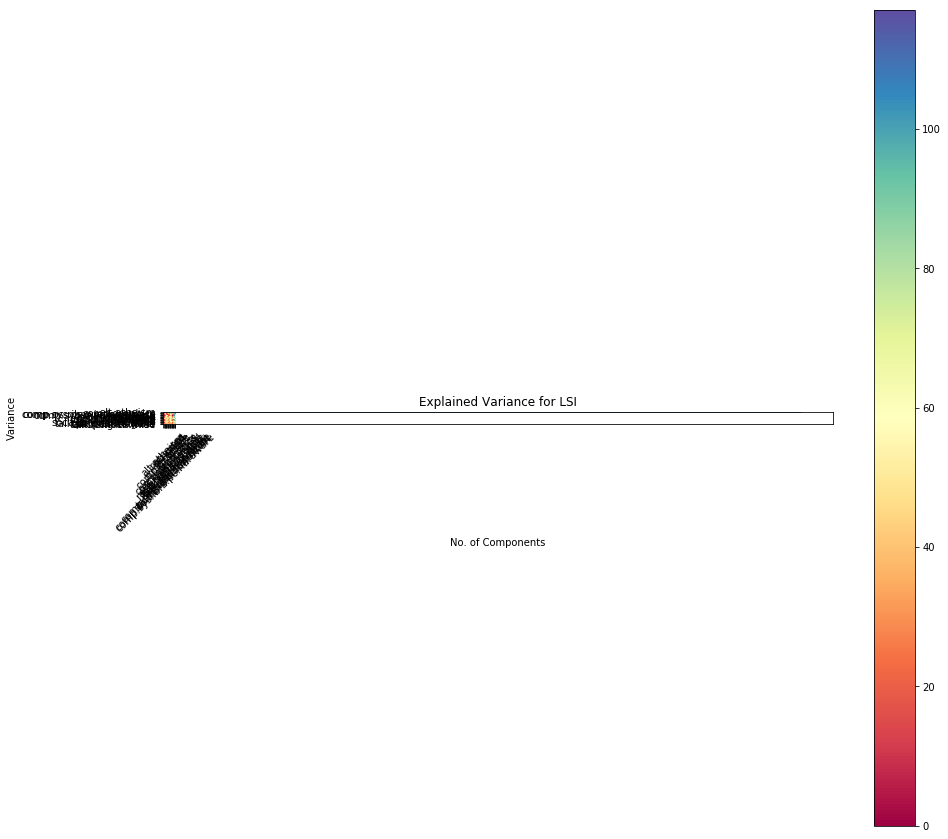

Shape of LSI Training Data ==> (18846L, 1000L)
Model with 1 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	5.62s	0	0.013	0.015	0.014	0.003	0.010


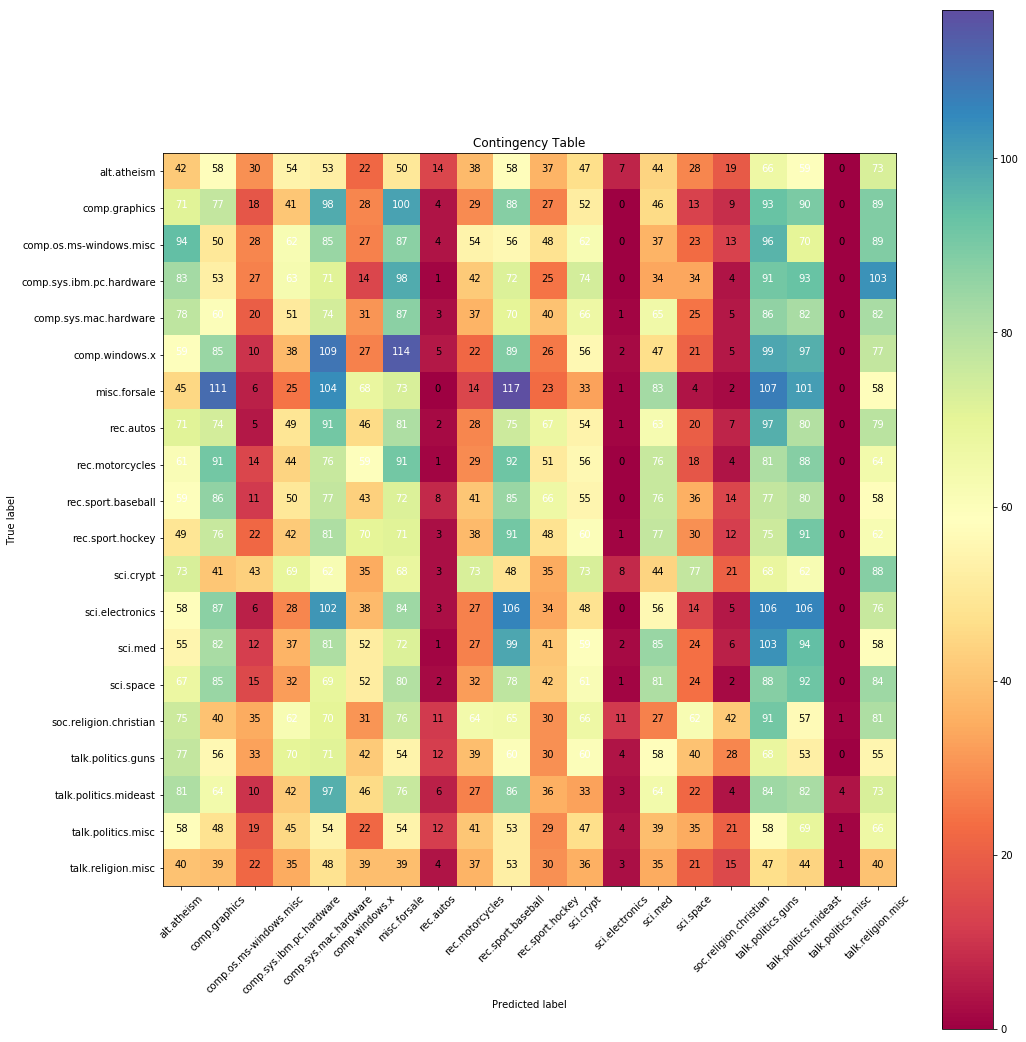

Model with 2 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	8.21s	9	0.152	0.162	0.157	0.043	0.150


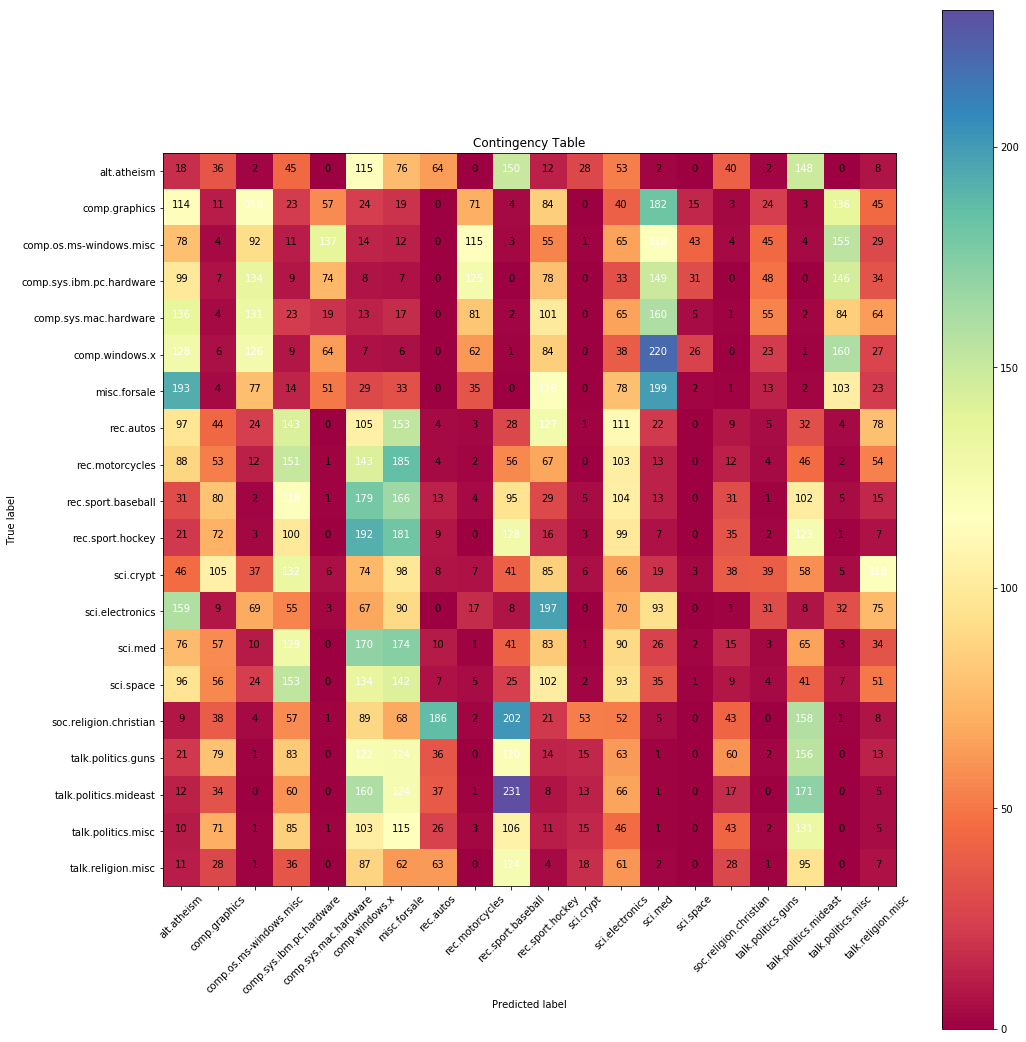

Model with 3 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	11.15s	23	0.201	0.217	0.209	0.064	0.199


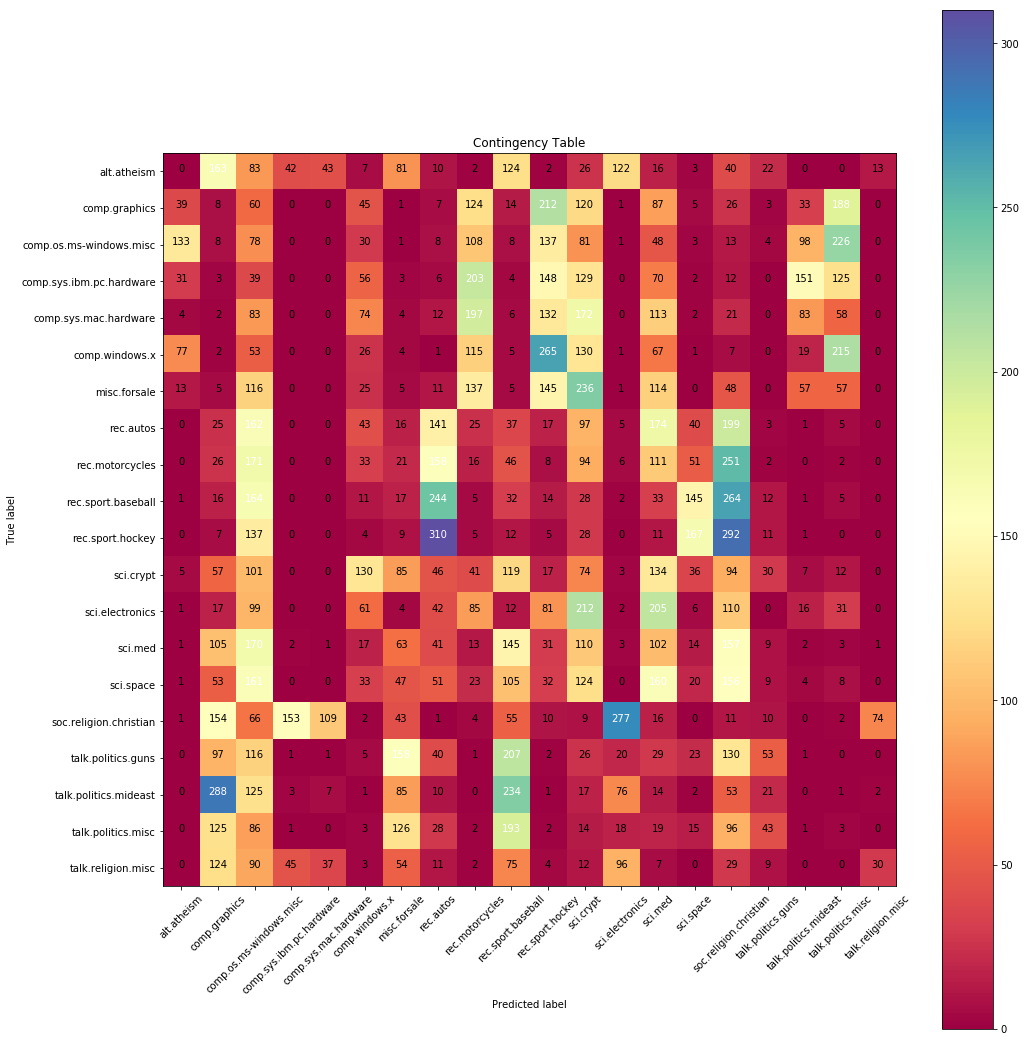

Model with 5 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	6.76s	61	0.199	0.221	0.209	0.061	0.197


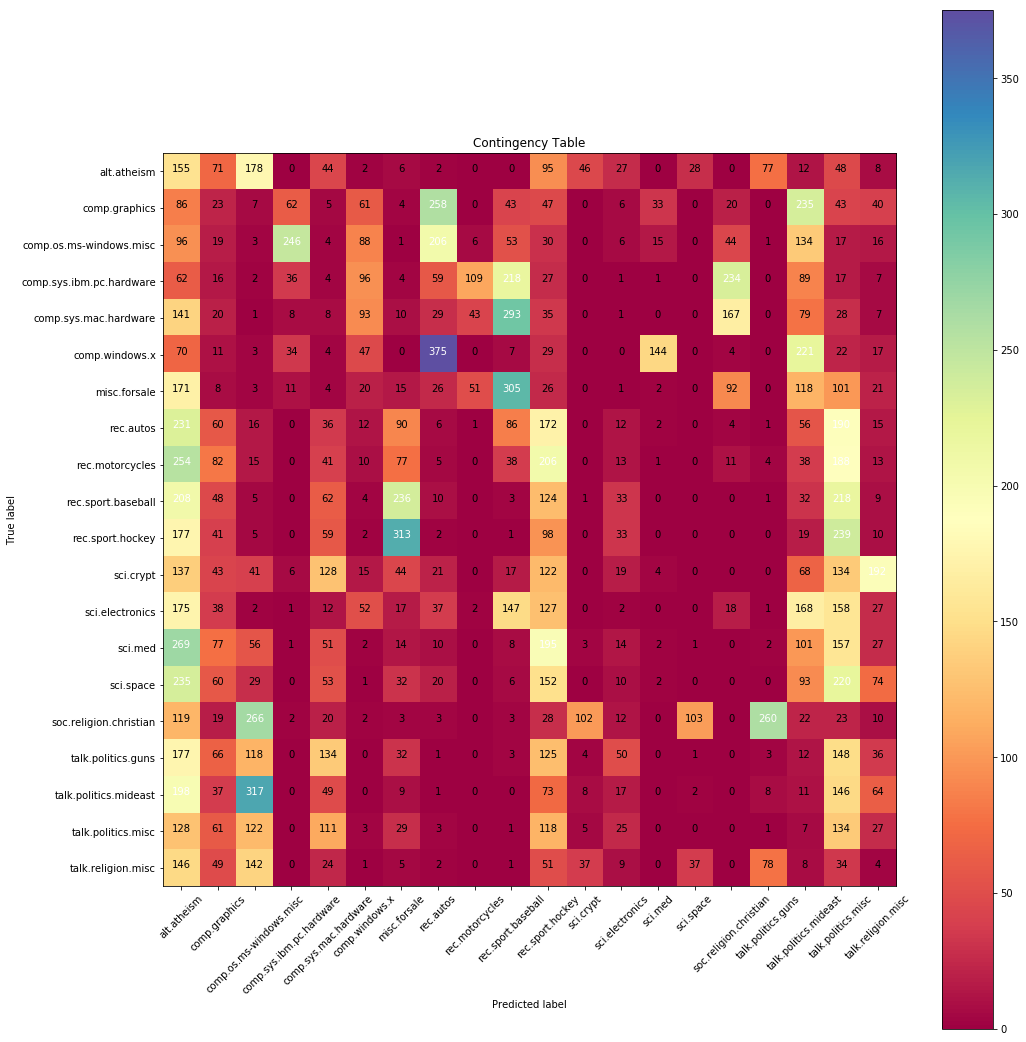

Model with 10 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	11.01s	148	0.230	0.259	0.244	0.072	0.227


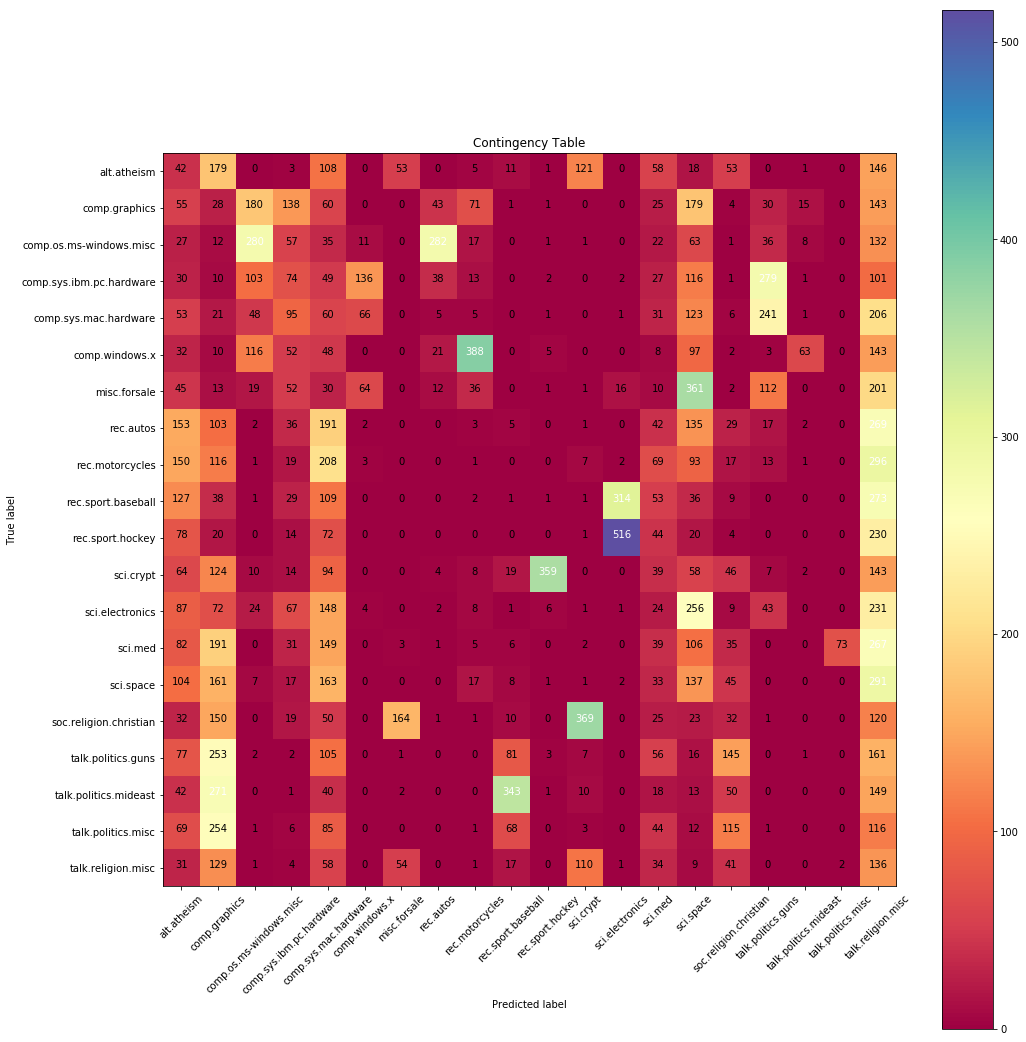

Model with 20 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	9.94s	334	0.264	0.299	0.280	0.081	0.261


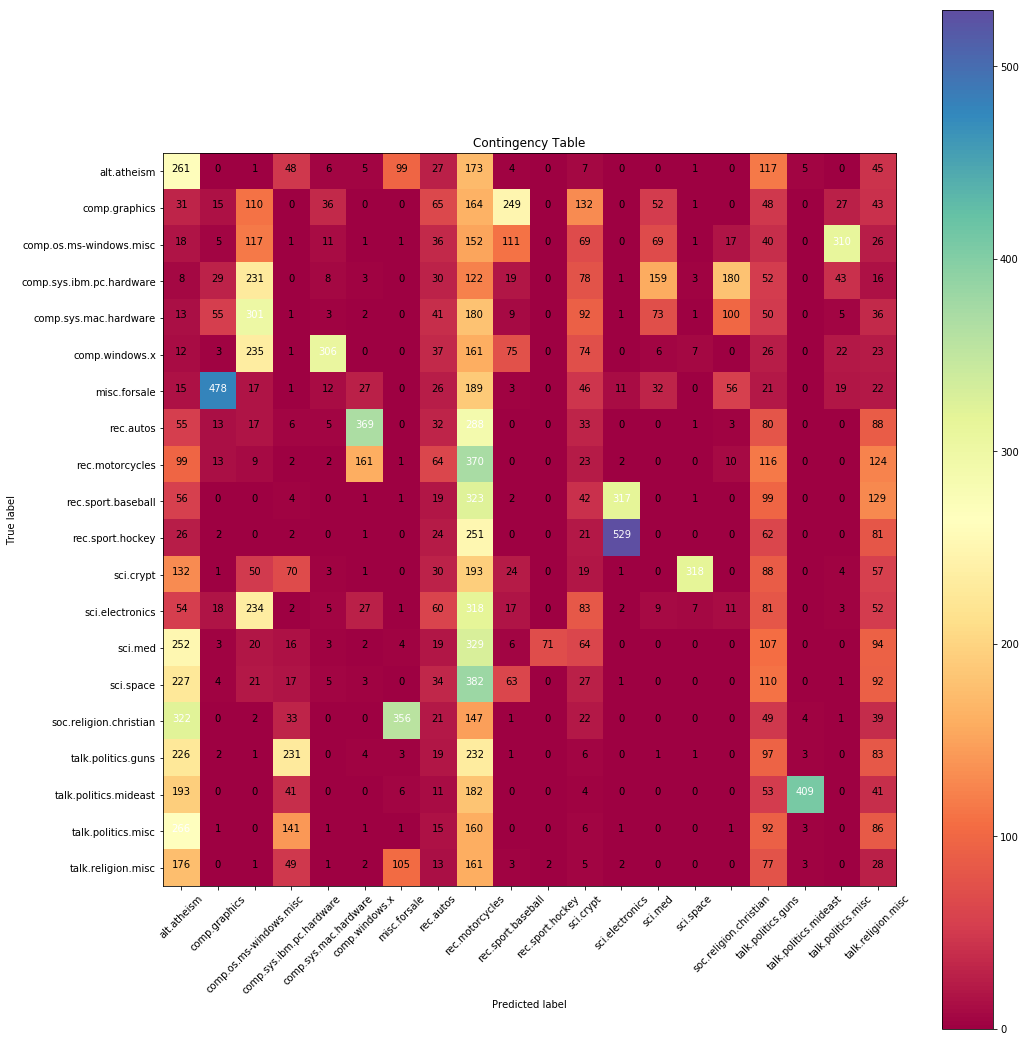

Model with 50 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	12.48s	860	0.253	0.315	0.281	0.057	0.250


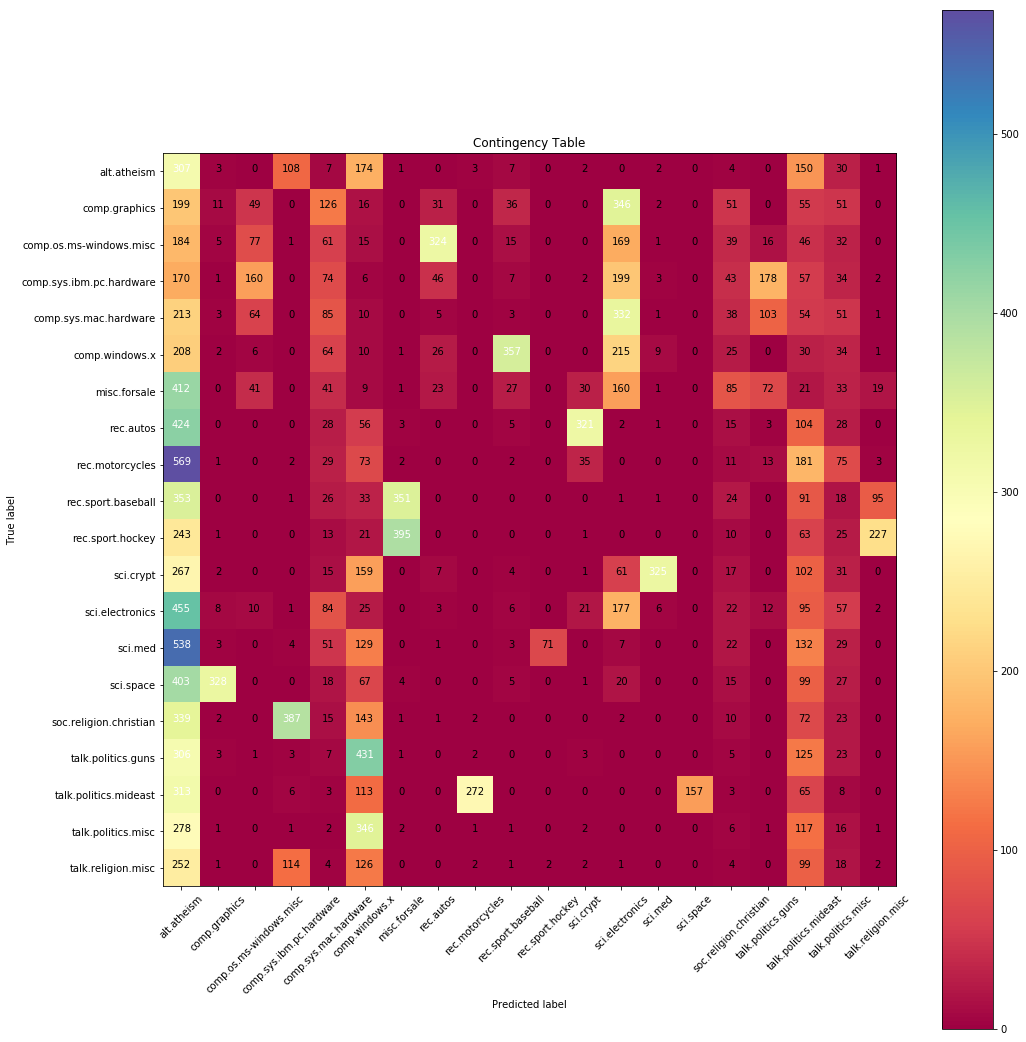

Model with 100 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	13.94s	1560	0.248	0.326	0.282	0.052	0.246


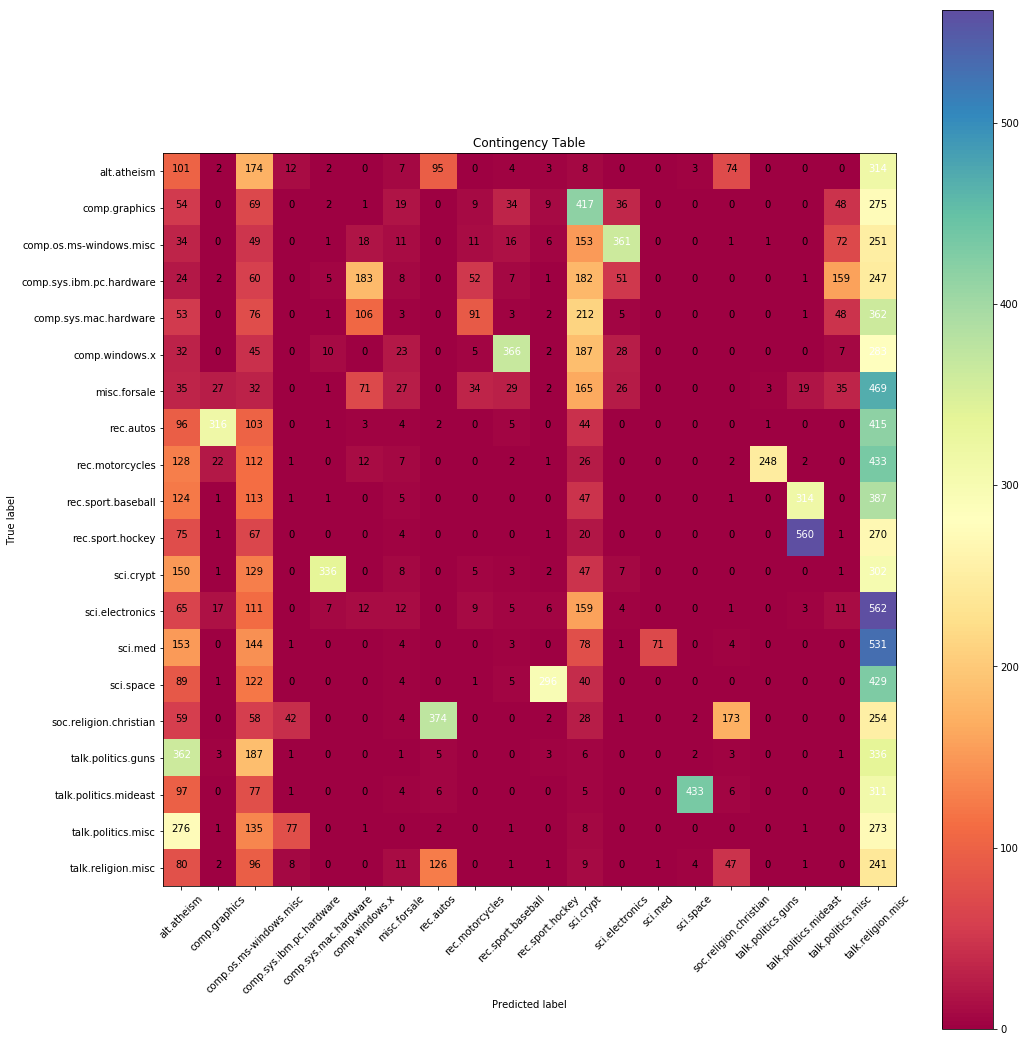

Model with 300 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	59.39s	3461	0.261	0.354	0.300	0.053	0.259


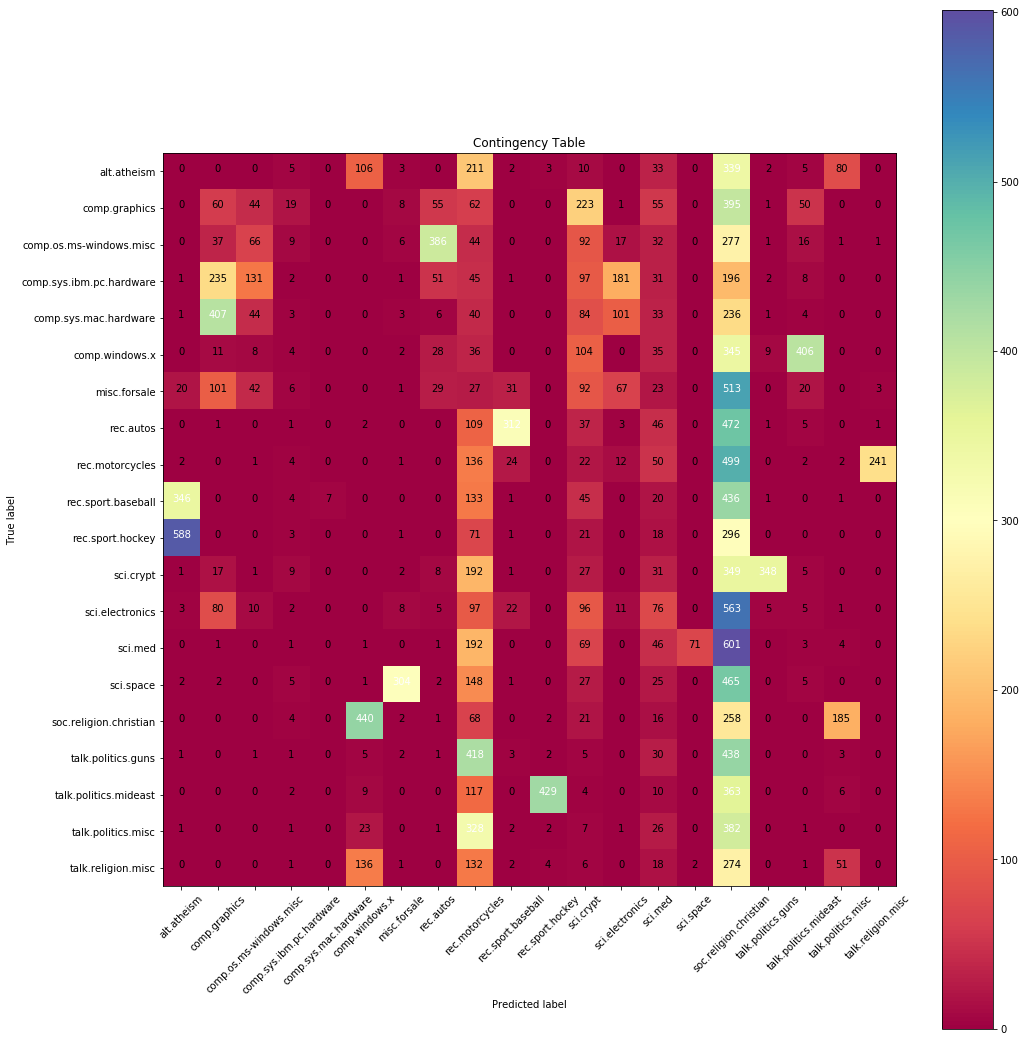

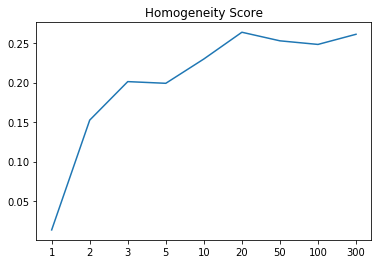

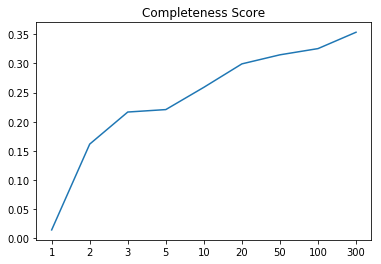

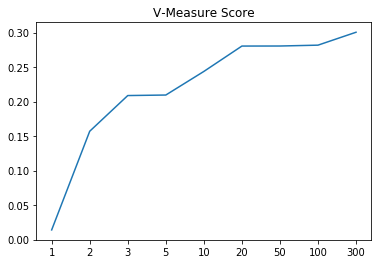

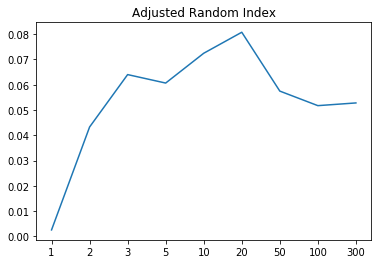

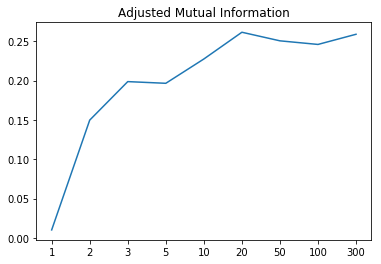

In [20]:
load_from_previous = True
#################### LSI ####################
def getLSI(data,lsi=None,isTrain=True):
    if(isTrain):
        lsi = TruncatedSVD(n_components=1000, n_iter=7, random_state=42)
        lsi_data = lsi.fit_transform(data)
    else:
        lsi_data = lsi.transform(data)
    return lsi,lsi_data


#################### LSI #######################
if(load_from_previous):
    model = load('models20/lsi_model')
    lsi = model['model']
    lsi_train = model['train']
else:    
    lsi,lsi_train = getLSI(training_data)
    save({'model':lsi,'train':lsi_train},'models20/lsi_model')
plt.plot(range(1,1001), lsi.explained_variance_ratio_ )
plt.xlabel('No. of Components')
plt.ylabel('Variance')
plt.title('Explained Variance for LSI')
plt.show()

lsi_models = []
componentList = [1, 2, 3, 5 ,10, 20, 50, 100,300]
print('Shape of LSI Training Data ==>', lsi_train.shape)
for i in componentList:
    print('Model with', i, 'components:')
    lsi_models.append(execKMeans(lsi_train[:,:i]))
visualize(lsi_models)

Model with 1 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	6.17s	0	0.013	0.015	0.014	0.003	0.010


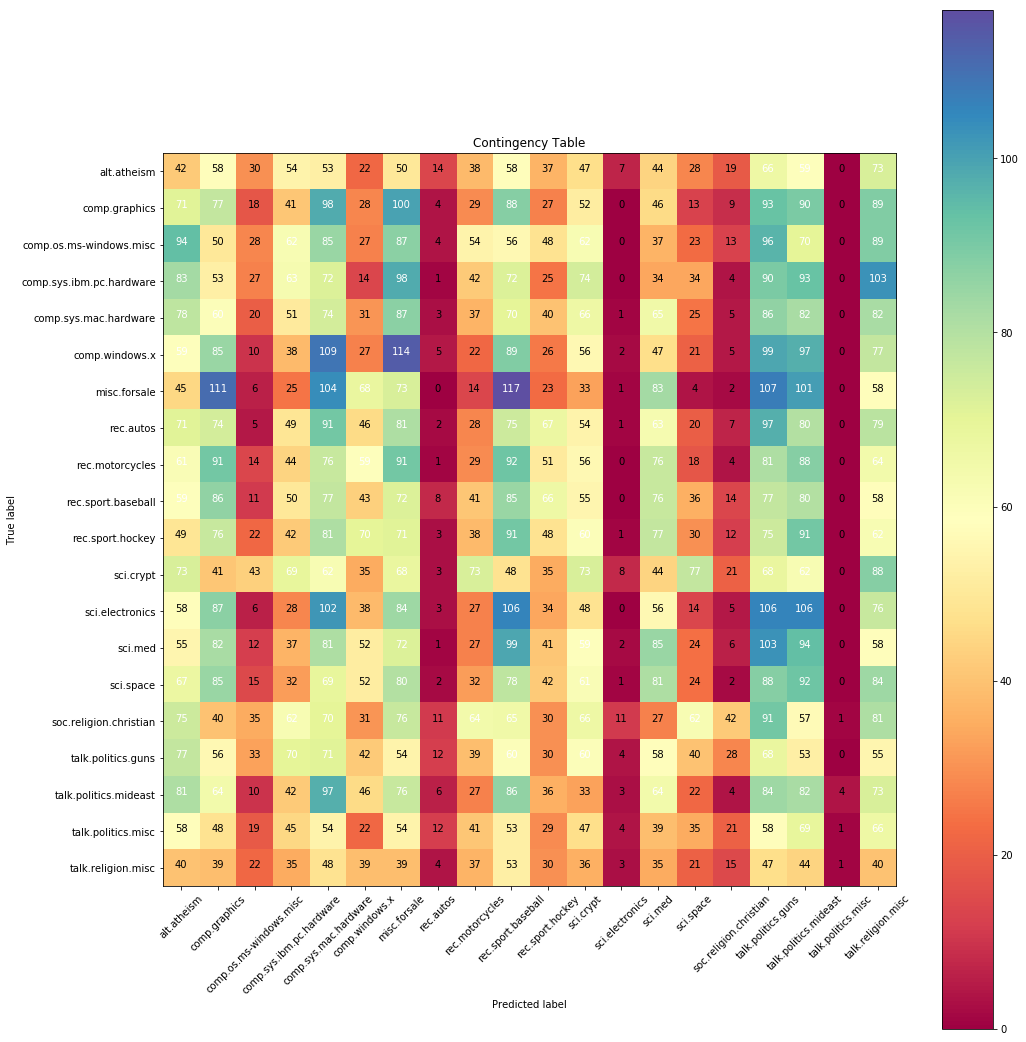

Model with 2 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	15.28s	0	0.143	0.154	0.149	0.041	0.141


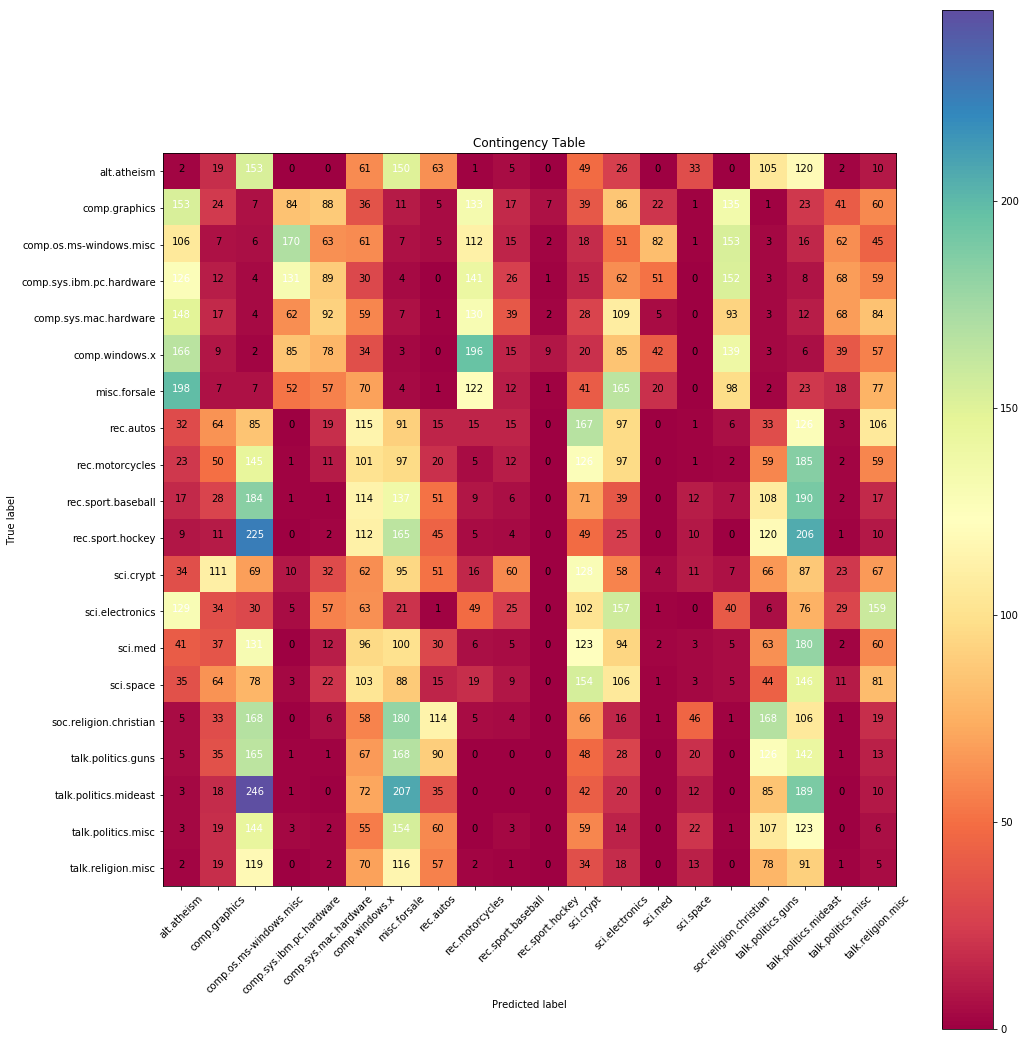

Model with 3 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	12.79s	0	0.181	0.199	0.190	0.052	0.178


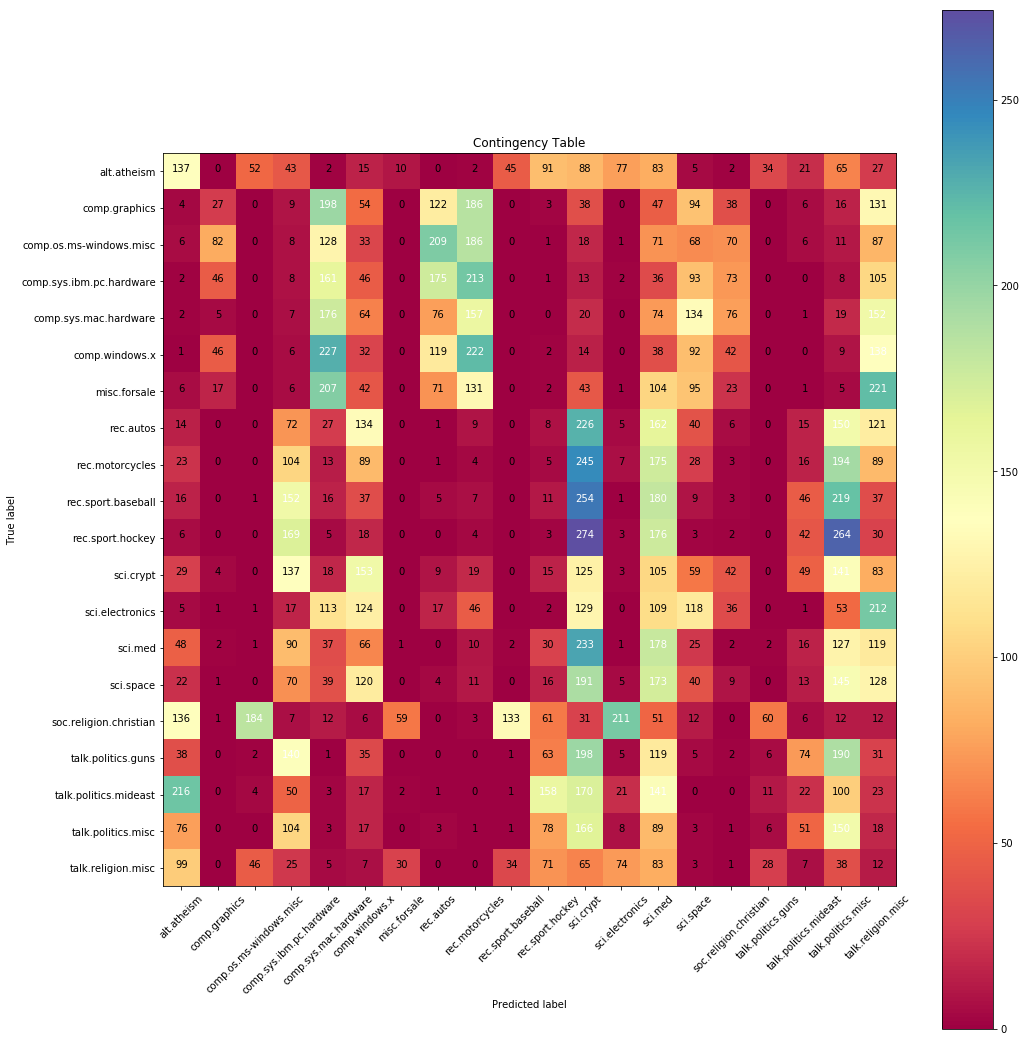

Model with 5 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	12.73s	1	0.174	0.191	0.182	0.049	0.171


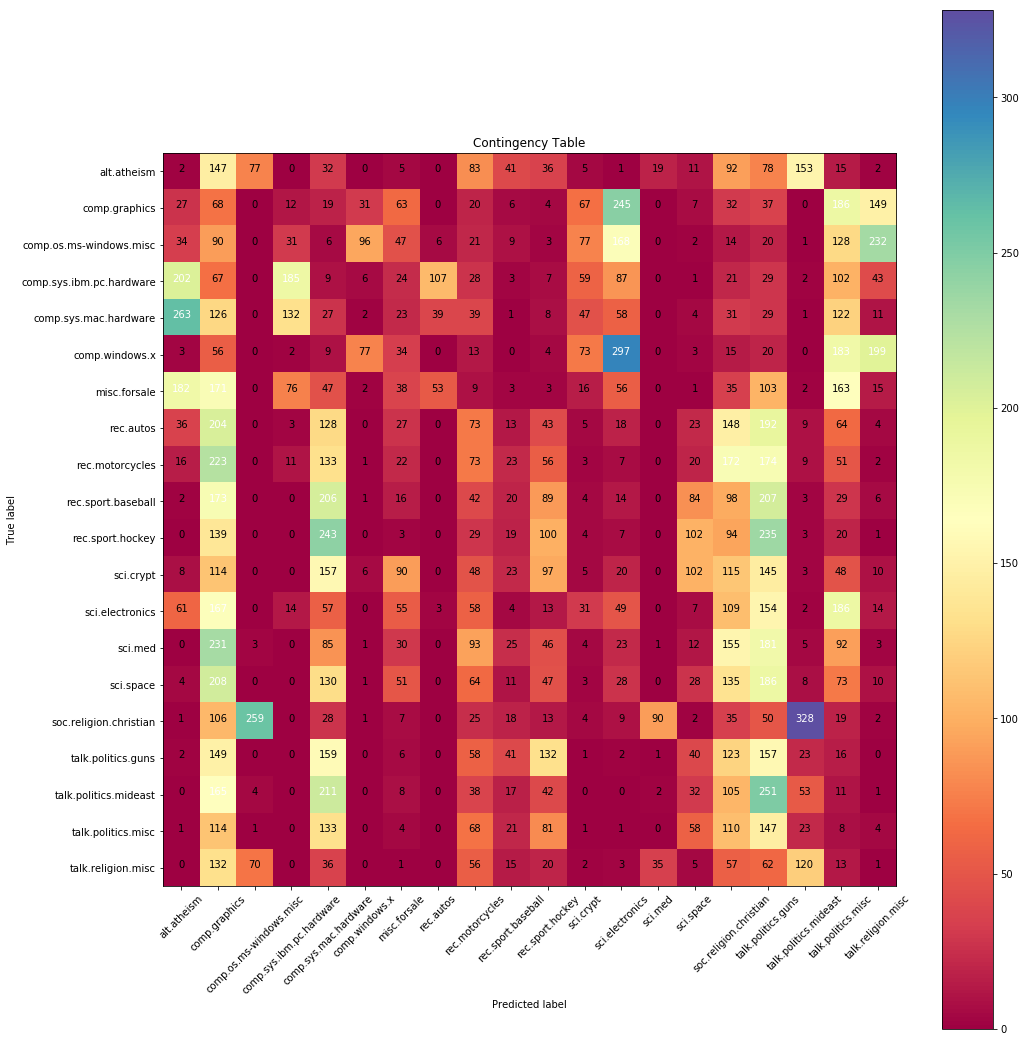

Model with 10 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	8.64s	6	0.214	0.248	0.230	0.057	0.212


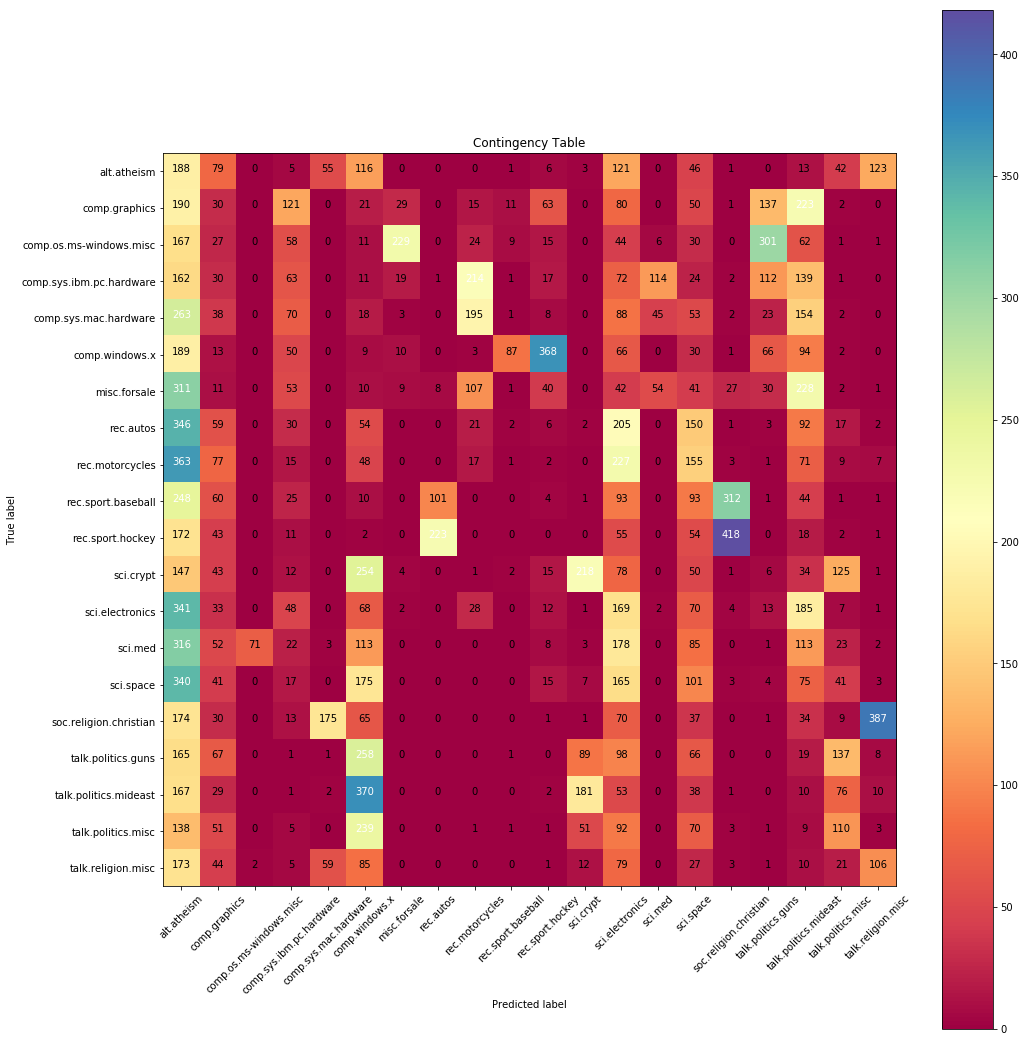

Model with 20 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	9.79s	19	0.227	0.281	0.251	0.049	0.225


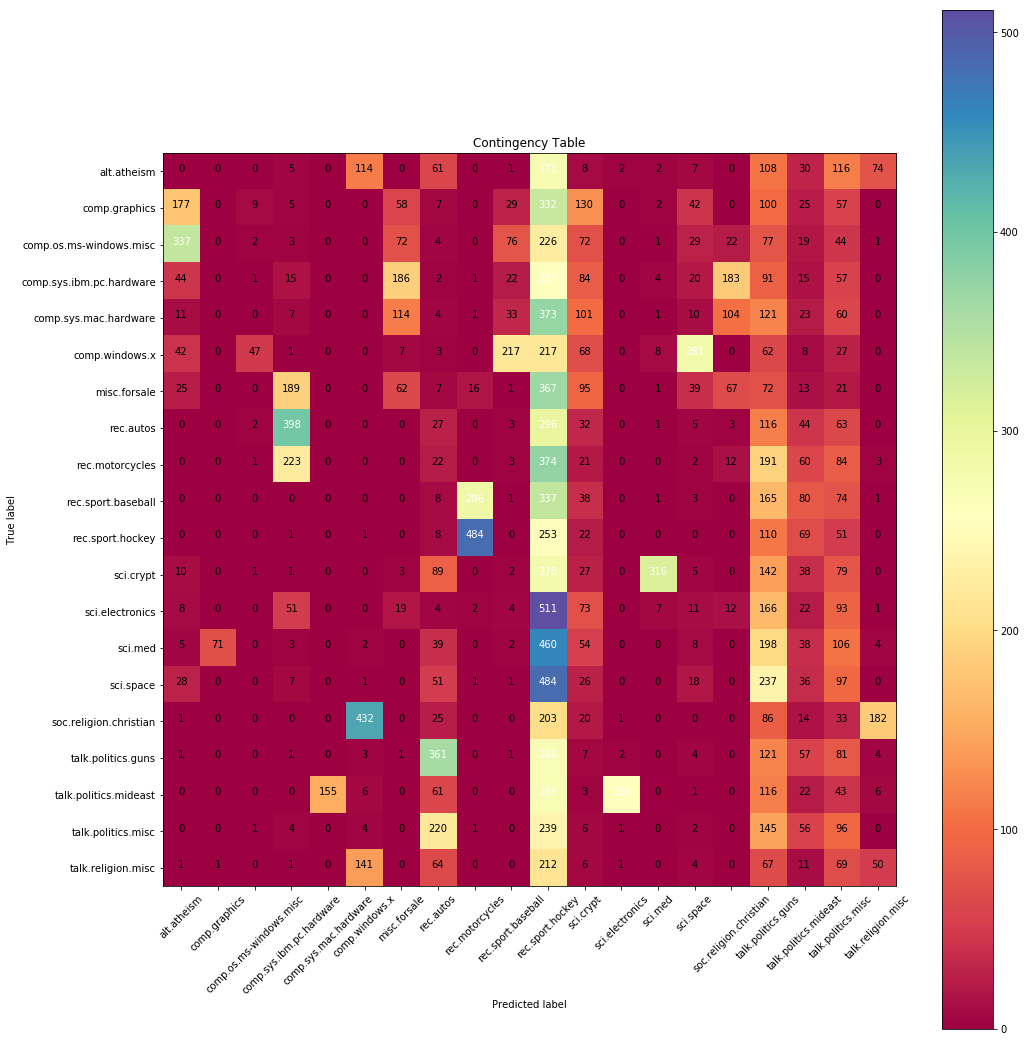

Model with 50 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	12.64s	70	0.179	0.258	0.211	0.033	0.176


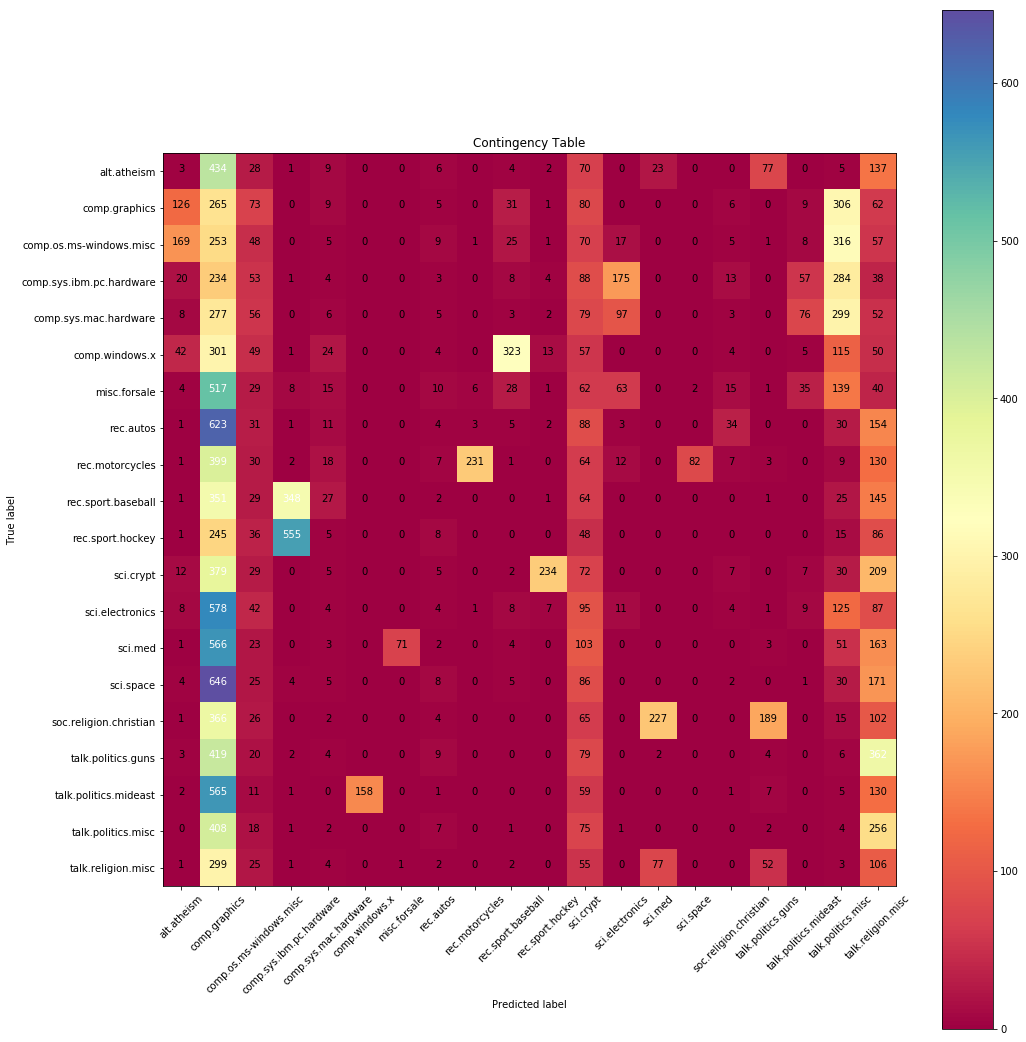

Model with 100 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	22.51s	158	0.102	0.149	0.121	0.016	0.099


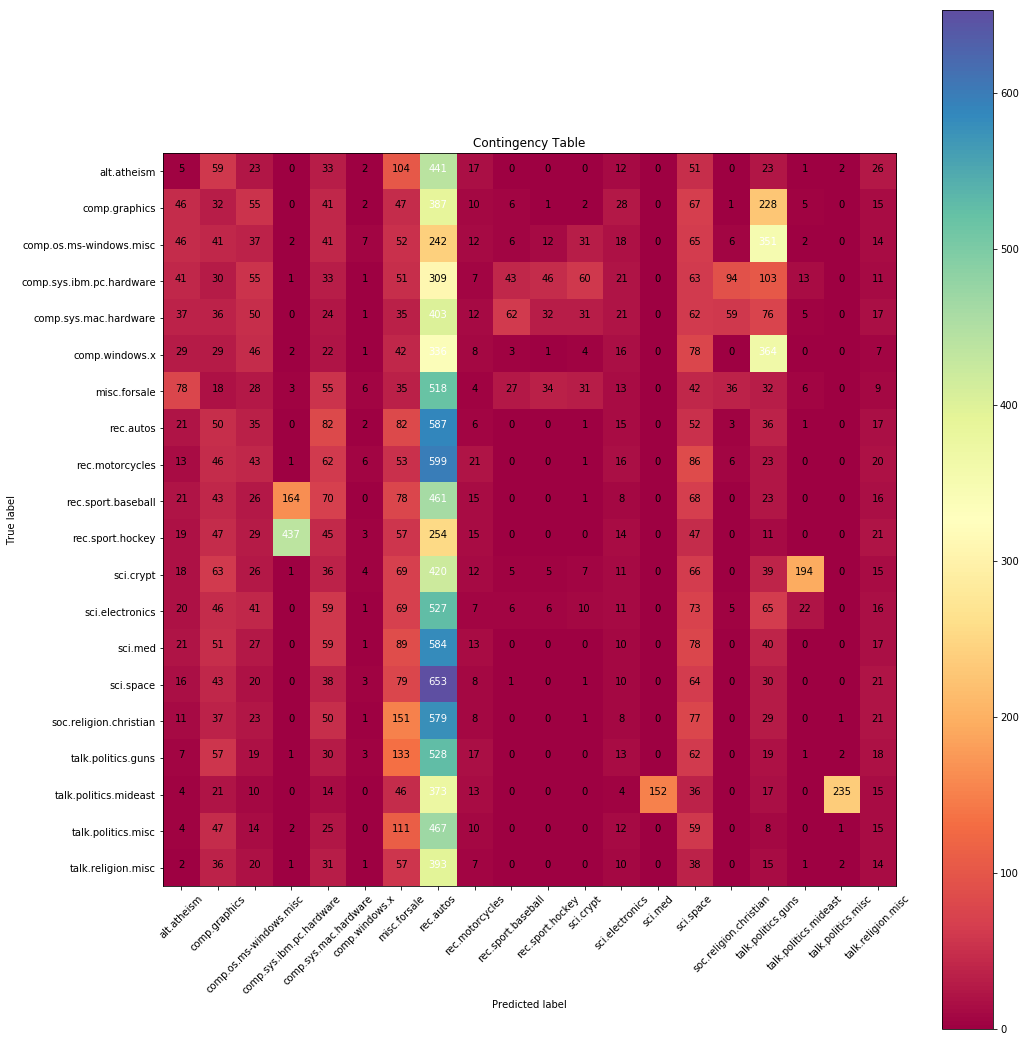

KeyboardInterrupt: 

In [21]:
load_from_previous = True

#################### NMF ####################
def getNMF(data,nmf=None,isTrain=True, n_comp=50):
    if(isTrain):
        nmf = NMF(n_components=n_comp, init='random', random_state=42)
        nmf_data = nmf.fit_transform(data)
    else:
        nmf_data = nmf.transform(data)
    return nmf,nmf_data

##################### NMF ####################
nmf_models = []
for i in componentList:
    if(load_from_previous):
        model = load('models20/nmf_model_'+str(i))
        nmf = model['model']
        nmf_train = model['train']
    else:    
        nmf,nmf_train = getNMF(training_data, n_comp=i)
        save({'model':nmf,'train':nmf_train},'models20/nmf_model_'+str(i))
    print('Model with', i, 'components:')
    nmf_models.append(execKMeans(nmf_train[:,:i]))
visualize(nmf_models)

# 4(a): Visualization

(18846L, 2L)


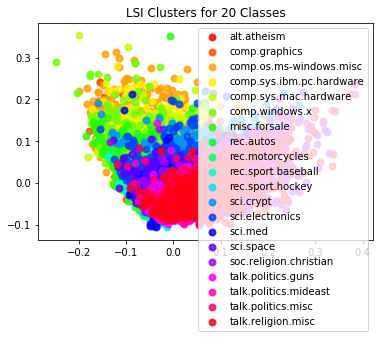

(18846L, 2L)


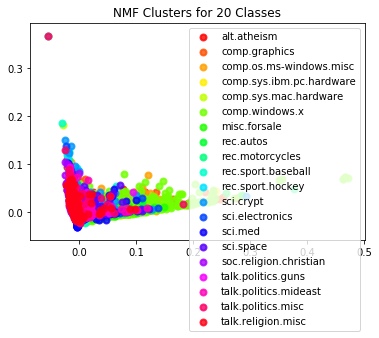

In [56]:
def visualizeClusters(data, title):
    #Visualization
    global target_names,labels
    colors = get_cmap(len(target_names))
    data = PCA(n_components=2).fit_transform(data)
    for i, target_name in zip(list(range(0,20)), target_names):
        plt.scatter(data[labels == i, 0], data[labels == i, 1], color=colors(i), alpha=.8, lw=2,
                    label=target_name)
    plt.legend(loc='best', labels=target_names)
    plt.title(title)
    plt.show()
    
n_comp = 20
model = load('models20/nmf_model_'+str(n_comp))
nmf = model['model']
nmf_train = model['train']
visualizeClusters(data=lsi_train, title='LSI Clusters for 20 Classes')
visualizeClusters(data=nmf_train, title='NMF Clusters for 20 Classes')

# 4(b)(i) : Normalizing

(18846L, 20L)
Before: [ 0.00310499  0.00405407  0.00260427  0.0023326   0.00226546  0.00212154
  0.00203022  0.00180087  0.00175648  0.00168441  0.00167577  0.00160169
  0.00156809  0.0015269   0.00142321  0.00137531  0.00127845  0.00125005
  0.00122171  0.00121013]
After: [  1.27371003e-05   5.25890683e-05   5.30610769e-05   5.30448820e-05
   5.25147196e-05   5.30258129e-05   5.29000738e-05   5.29687796e-05
   5.26354541e-05   5.29403305e-05   5.30534540e-05   5.29317389e-05
   5.30331856e-05   5.30569745e-05   5.30319103e-05   5.30599761e-05
   5.30166342e-05   5.29950212e-05   5.29755053e-05   5.30611852e-05]
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	13.68s	9	0.235	0.285	0.258	0.058	0.233


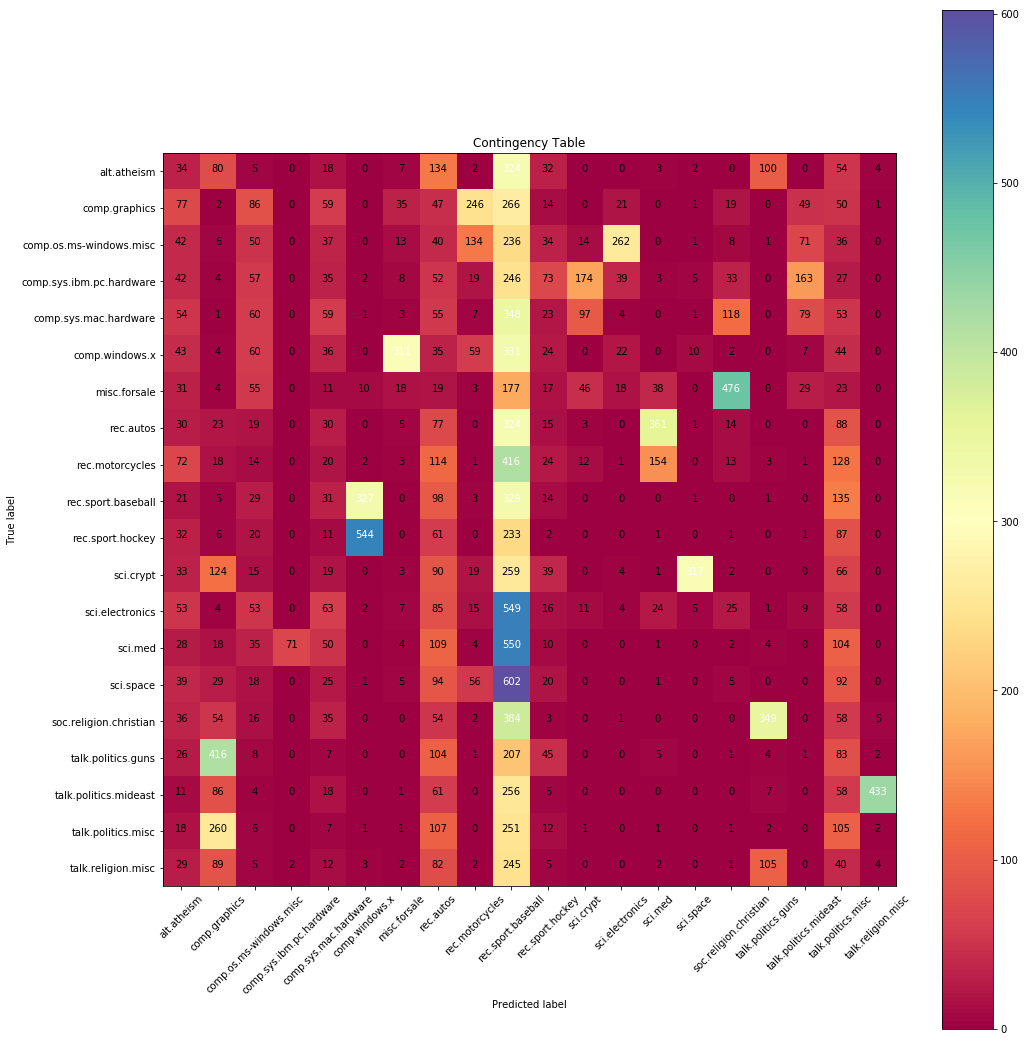

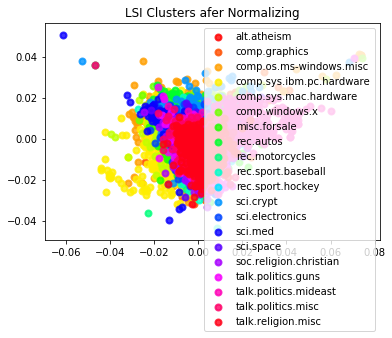

(18846L, 20L)
Before: [  3.52443812e-04   4.94481574e-04   1.67679684e-04   1.20697037e-04
   8.90593422e-05   7.40433819e-05   1.04685148e-04   1.00544368e-04
   7.95543407e-05   5.01481495e-05   1.96930614e-04   9.22249580e-05
   7.61478936e-05   1.05993788e-04   1.20356235e-04   1.26452435e-04
   2.00494846e-04   1.18279879e-04   1.32340519e-04   2.12876513e-04]
After: [  3.78785779e-05   5.06393379e-05   4.54514913e-05   4.99999137e-05
   5.08766052e-05   4.30688412e-05   4.70063229e-05   4.45296082e-05
   4.98559200e-05   4.35279407e-05   5.07985284e-05   3.69144989e-05
   4.42459607e-05   3.92246977e-05   4.04103406e-05   4.56749535e-05
   5.22070587e-05   4.80363542e-05   5.08929852e-05   4.89168503e-05]
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	10.17s	6	0.245	0.304	0.271	0.054	0.243


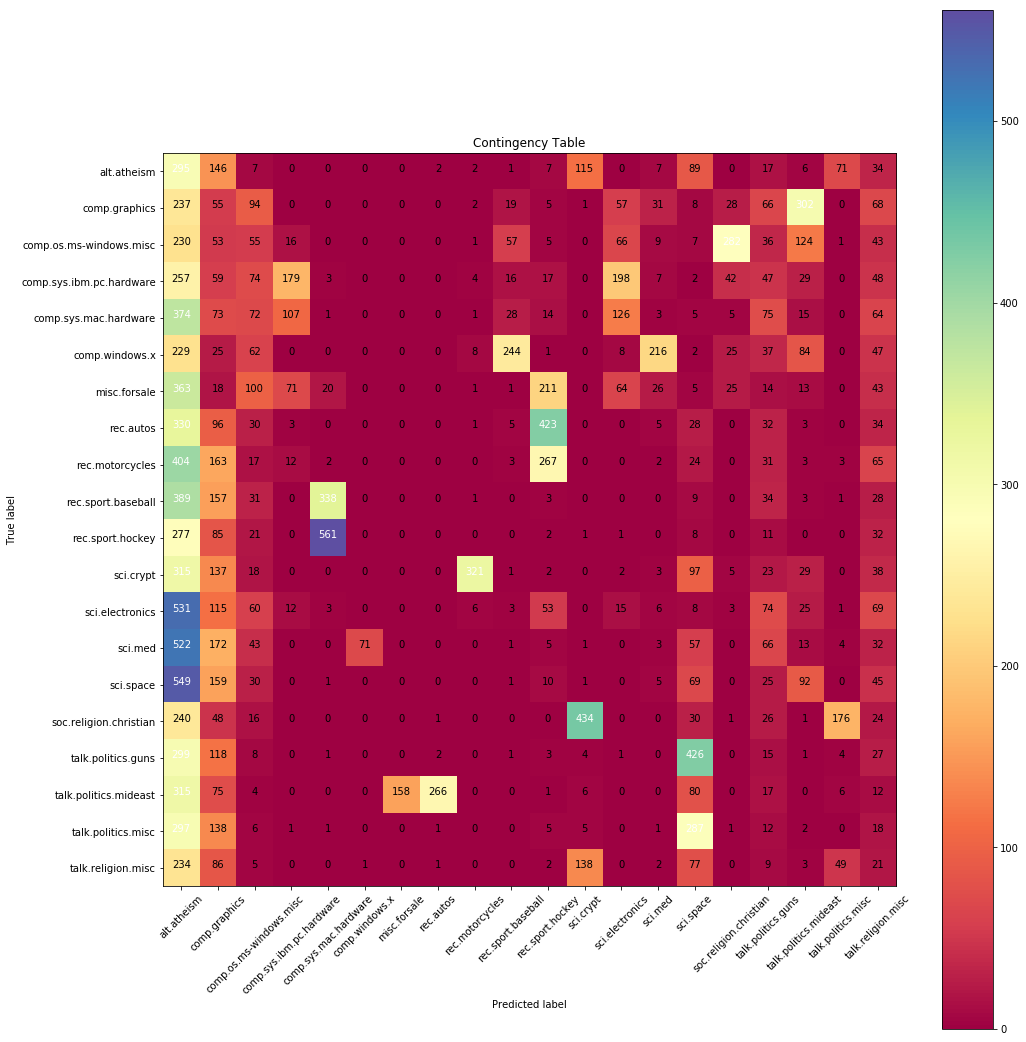

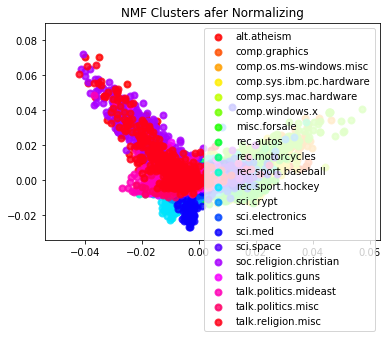

In [46]:
norm_lsi_train = normalize(lsi_train[:,:n_comp], axis=0)
print(norm_lsi_train.shape)
print('Before:', np.var(lsi_train[:,:n_comp], axis=0))
print('After:', np.var(norm_lsi_train, axis=0))
execKMeans(norm_lsi_train[:,:n_comp])
visualizeClusters(norm_lsi_train, 'LSI Clusters afer Normalizing')

model = load('models20/nmf_model_'+str(n_comp))
nmf = model['model']
nmf_train = model['train']
norm_nmf_train = normalize(nmf_train, axis=0)
print(norm_nmf_train.shape)
print('Before:', np.var(nmf_train, axis=0))
print('After:', np.var(norm_nmf_train, axis=0))
execKMeans(norm_nmf_train)
visualizeClusters(norm_nmf_train, 'NMF Clusters afer Normalizing')


# 4(b)(ii): Logarithmic Transformation

(18846L, 20L)
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	22.77s	253625	0.302	0.304	0.303	0.156	0.299


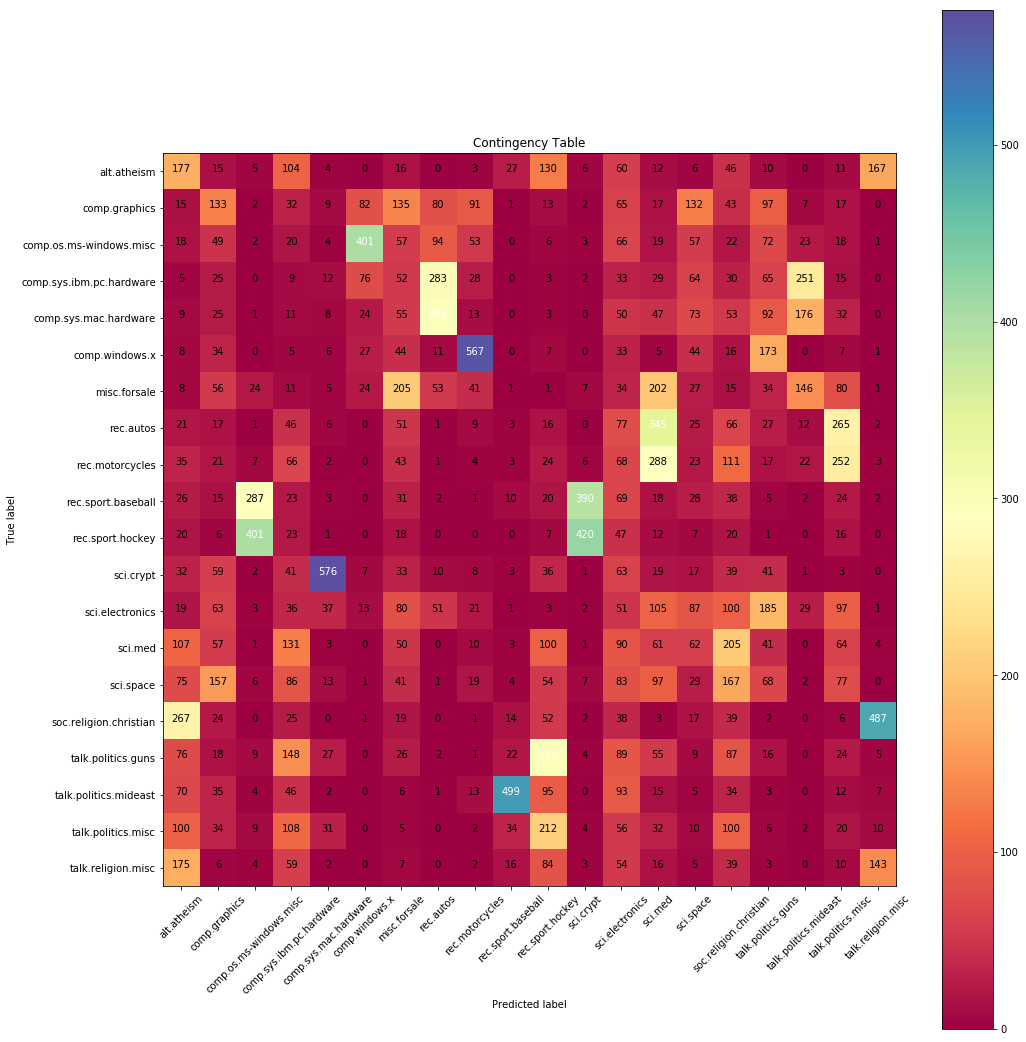

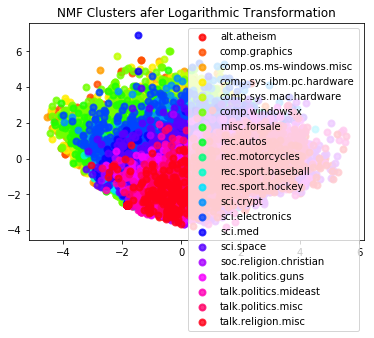

In [47]:
model = load('models20/nmf_model_'+str(n_comp))
nmf = model['model']
nmf_train = model['train']
log_nmf_train = np.log(nmf_train+0.001)
print(log_nmf_train.shape)
execKMeans(log_nmf_train)
visualizeClusters(log_nmf_train, 'NMF Clusters afer Logarithmic Transformation')


# 4(b)(iii): Logarithmic Transformation and Normalization

(18846L, 20L)
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	23.44s	253625	0.302	0.304	0.303	0.156	0.299


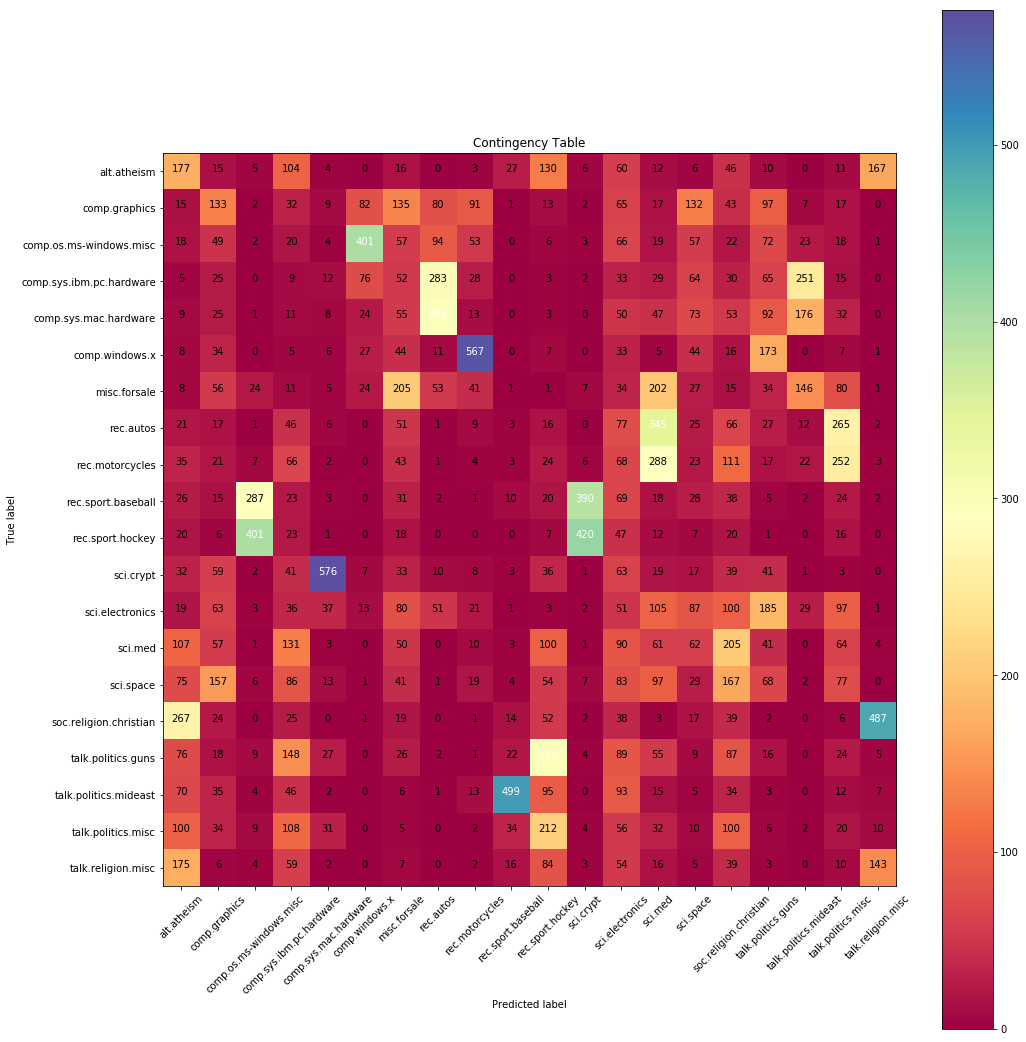

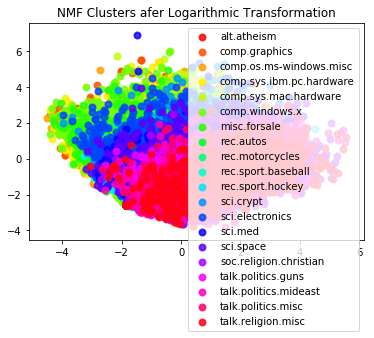

(18846L, 20L)
Before: [ 2.24611746  1.09146161  1.37205868  0.8188437   0.61406914  1.27528262
  1.05225816  1.3030639   0.74023238  1.06511394  0.775032    1.54331058
  1.15710725  1.44880144  1.46871463  1.27223351  0.53817193  1.0749914
  0.67959483  1.1532678 ]
After: [  3.78450120e-06   1.38344267e-06   1.96215467e-06   1.02301543e-06
   7.71938413e-07   1.77867112e-06   1.41284765e-06   1.80085646e-06
   9.08167661e-07   1.46658141e-06   9.53643029e-07   2.41031169e-06
   1.61537747e-06   2.25767104e-06   2.27416738e-06   1.78782169e-06
   6.48863482e-07   1.39836565e-06   8.47852636e-07   1.54193869e-06]
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	21.44s	0	0.286	0.287	0.286	0.138	0.283


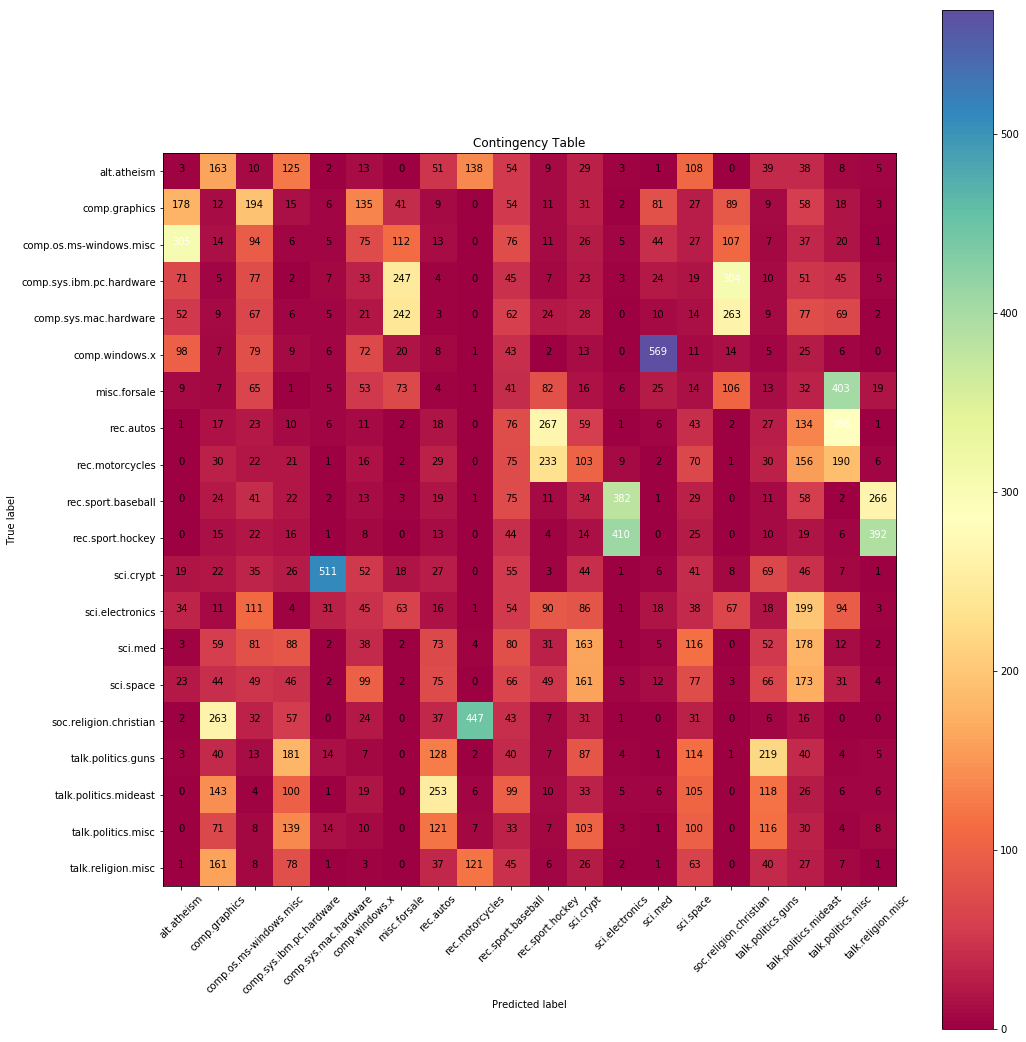

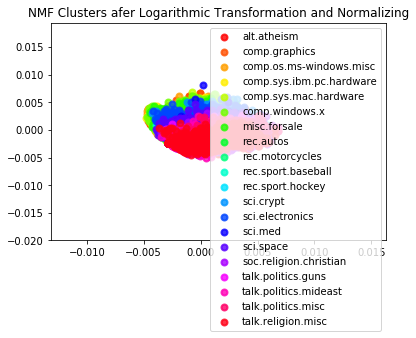

In [48]:
#Take Log and then normalize
model = load('models20/nmf_model_'+str(n_comp))
nmf = model['model']
nmf_train = model['train']
log_nmf_train = np.log(nmf_train+0.001)
print(log_nmf_train.shape)
execKMeans(log_nmf_train)
visualizeClusters(log_nmf_train, 'NMF Clusters afer Logarithmic Transformation')

#Now Normalize
norm_log_nmf_train = normalize(log_nmf_train, axis=0)
print(norm_log_nmf_train.shape)
print('Before:', np.var(log_nmf_train, axis=0))
print('After:', np.var(norm_log_nmf_train, axis=0))
execKMeans(norm_log_nmf_train)
visualizeClusters(norm_log_nmf_train, 'NMF Clusters afer Logarithmic Transformation and Normalizing')


# Normalization and Logarithmic Transformation

(18846L, 20L)
Before: [  3.52443812e-04   4.94481574e-04   1.67679684e-04   1.20697037e-04
   8.90593422e-05   7.40433819e-05   1.04685148e-04   1.00544368e-04
   7.95543407e-05   5.01481495e-05   1.96930614e-04   9.22249580e-05
   7.61478936e-05   1.05993788e-04   1.20356235e-04   1.26452435e-04
   2.00494846e-04   1.18279879e-04   1.32340519e-04   2.12876513e-04]
After: [  3.78785779e-05   5.06393379e-05   4.54514913e-05   4.99999137e-05
   5.08766052e-05   4.30688412e-05   4.70063229e-05   4.45296082e-05
   4.98559200e-05   4.35279407e-05   5.07985284e-05   3.69144989e-05
   4.42459607e-05   3.92246977e-05   4.04103406e-05   4.56749535e-05
   5.22070587e-05   4.80363542e-05   5.08929852e-05   4.89168503e-05]
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	10.11s	6	0.245	0.304	0.271	0.054	0.243


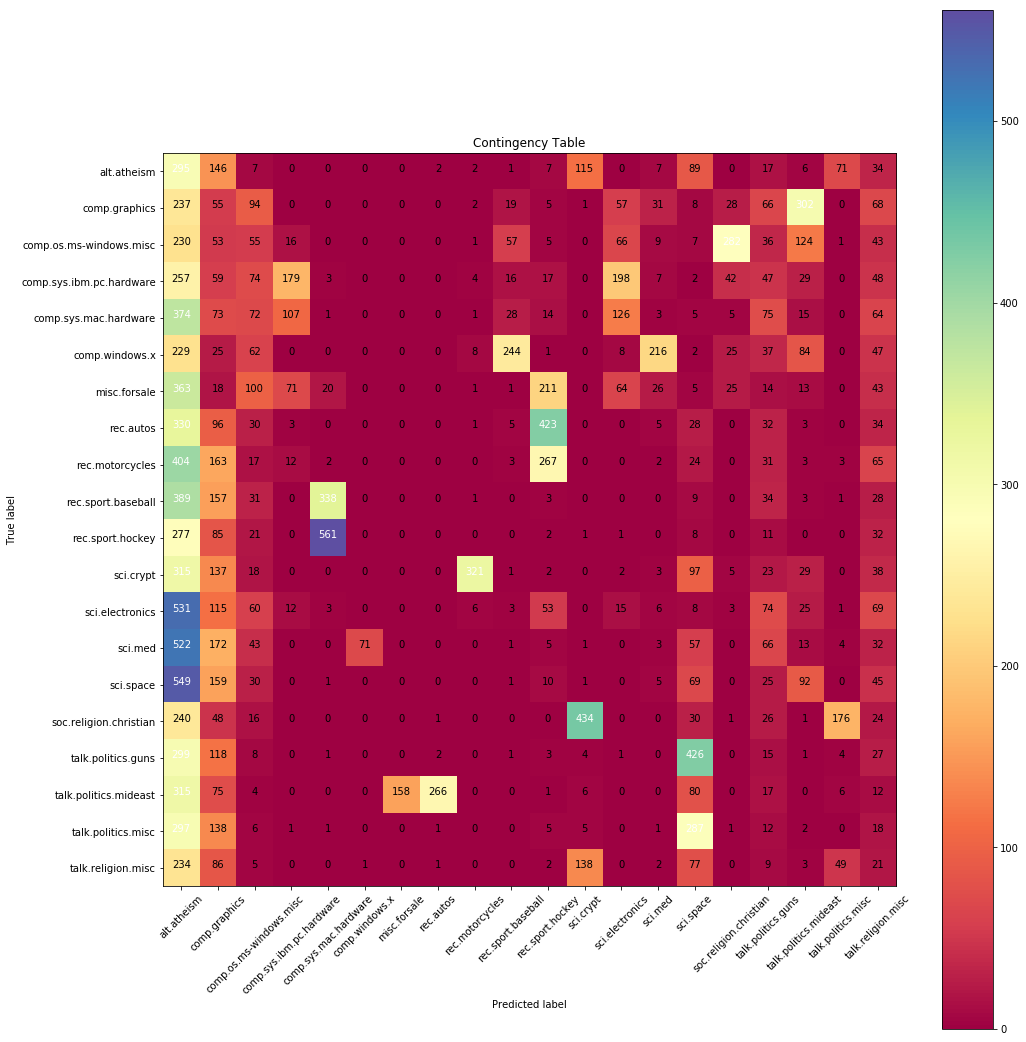

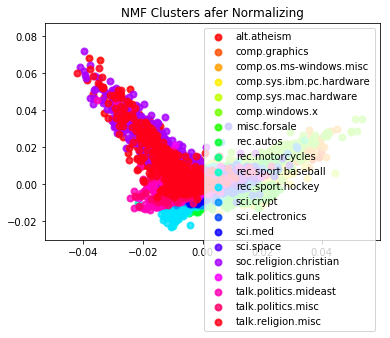

(18846L, 20L)
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	22.52s	176083	0.313	0.315	0.314	0.161	0.311


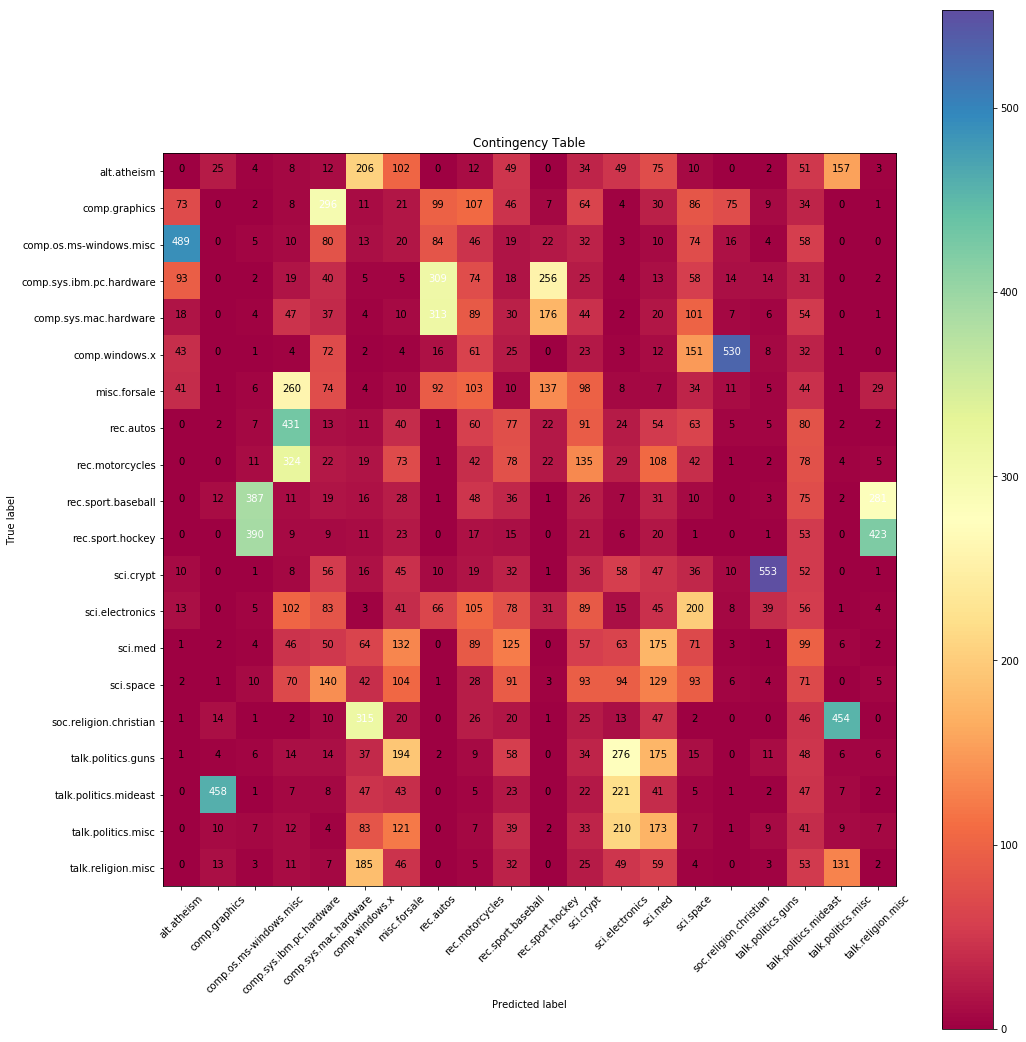

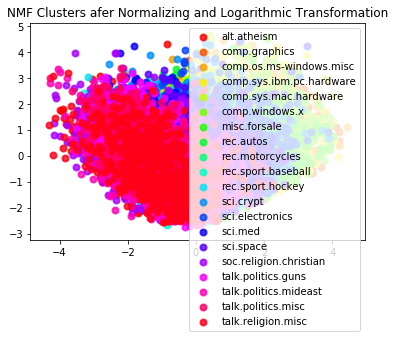

In [49]:
#Normalzie and then take Log
model = load('models20/nmf_model_'+str(n_comp))
nmf = model['model']
nmf_train = model['train']
norm_nmf_train = normalize(nmf_train, axis=0)
print(norm_nmf_train.shape)
print('Before:', np.var(nmf_train, axis=0))
print('After:', np.var(norm_nmf_train, axis=0))
execKMeans(norm_nmf_train)
visualizeClusters(norm_nmf_train, 'NMF Clusters afer Normalizing')

#Now take Log
log_norm_nmf_train = np.log(norm_nmf_train+0.001)
print(log_norm_nmf_train.shape)
execKMeans(log_norm_nmf_train)
visualizeClusters(log_norm_nmf_train, 'NMF Clusters afer Normalizing and Logarithmic Transformation')
